In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.27G/2.29G [00:19<00:00, 97.8MB/s]
100% 2.29G/2.29G [00:20<00:00, 123MB/s] 


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/chest-xray-pneumonia.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
pip install glob2

Import all the necessary modules that are available in keras like ImageDataGenerator, Model, Dense, Flatten and all. We will be creating a generic code which means that we just have to change the library name then our code will automatically work with respect to VGG16, VGG19 and resnet50.

In [ ]:
from keras.models import Model
from keras.layers import Flatten,Dense
from keras.applications.vgg19 import VGG19
import matplotlib.pyplot as plot
from glob import glob
from tensorflow.keras.layers import Input


After this, we will provide our image size i.e 224 x 224 this is a fixed-size for VGG16 architecture. 3 signifies that we are working with RGB type of images. Then we will provide our training and testing data path.

In [ ]:
IMAGESHAPE = [224, 224, 3]
training_data = '/content/chest_xray/train'
testing_data = '/content/chest_xray/test'


Now, we will import our VGG16 model. While importing we will use the weights of the imageNet & include_top=False signifies that we do not want to classify 1000 different categories present in imageNet our problem is all about two categories Pneumonia and Normal that’s why we are just dropping the first and last layers then we will just design our own layers and add it into VGG16

In [ ]:
vgg_model = VGG19(input_shape=IMAGESHAPE, weights='imagenet', include_top=False)


80134624/80134624 [==============================] - 0s 0us/step


After importing VGG16 model, we have to make this important change. By using the for loop iterating over all layers and setting the trainable as False, so that all the layers would not be trained.

In [ ]:
for each_layer in vgg_model.layers:
	each_layer.trainable = False


We will try to see how many classes are present in our train dataset to understand how many output labels we should have.

In [ ]:
classes = glob('/content/chest_xray/train/*')


As we deleted the first and the last columns in the previous step, We will just make a flattened layer and finally we just add our last layer with a softmax activation function. len(classes) indicate how many categories we have in our output layer.

In [ ]:
flatten_layer = Flatten()(vgg_model.output)
prediction = Dense(len(classes), activation='softmax')(flatten_layer)


Now we will combine the VGG output and prediction, this all together will create a model. When we check the model summary we can observe that the last layer have only two categories.

In [ ]:
final_model = Model(inputs=vgg_model.input, outputs=prediction)
final_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Now we will compile our model using adam optimizer and optimization metric as accuracy.

In [ ]:
final_model.compile(
loss='categorical_crossentropy',
optimizer='adam',
metrics=['accuracy']
)


After compiling the model, we have to import our dataset to Keras using ImageDataGenerator in Keras. For creating additional features we use metrics like rescale, shear_range, zoom_range these will help us in the training and testing phases.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
								shear_range = 0.2,
								zoom_range = 0.2,
								horizontal_flip = True)
testing_datagen = ImageDataGenerator(rescale =1. / 255)



Now we will insert the images using flow_from_directory() function. Make sure that here we have to pass the same image size as we initiated earlier. Batch size 4 indicates that at once 4 images will be given for training. Class_mode is Categorical i.e either Pneumonia or Not Pneumonia.

In [ ]:
training_set = train_datagen.flow_from_directory('/content/chest_xray/train',
												target_size = (224, 224),
												batch_size = 4,
												class_mode = 'categorical')


Found 5216 images belonging to 2 classes.


Similarly, we will do the same for the test dataset what we did for the train dataset.

In [ ]:
test_set = testing_datagen.flow_from_directory('/content/chest_xray/test',
											target_size = (224, 224),
											batch_size = 4,
											class_mode = 'categorical')


Found 624 images belonging to 2 classes.


Finally, we are fitting the model using fit_generator() function and passing all the necessary details regarding our training and testing dataset as arguments. This will take some time to execute

In [ ]:
fitted_model = final_model.fit_generator(
training_set,
validation_data=test_set,
epochs=2
                                          ,
steps_per_epoch=len(training_set),
validation_steps=len(test_set)
)


Epoch 1/2


<ipython-input-26-44c2ddb95b84>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  fitted_model = final_model.fit_generator(


1304/1304 [==============================] - 148s 114ms/step - loss: 0.3179 - accuracy: 0.9371 - val_loss: 0.6939 - val_accuracy: 0.8942
Epoch 2/2
1304/1304 [==============================] - 128s 98ms/step - loss: 0.3551 - accuracy: 0.9402 - val_loss: 0.7845 - val_accuracy: 0.9022


Create a model file and store this model. So that we don’t need to train the model every time we gave input

In [ ]:
final_model.save('our_model.h5')


Load the model that we created. Now read an image and preprocess the image finally we check what output our model is giving using model.predict() function.

In [ ]:
pip install keras_preprocessing


1/1 [==============================] - 1s 754ms/step
Person is affected with Pneumonia.
Predictions: [[0. 1.]]


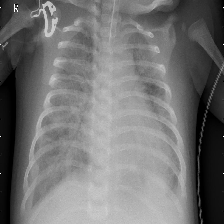

In [ ]:
from keras_preprocessing import image
from keras.models import load_model
from keras.applications.vgg16 import preprocess_input
import numpy as np
model=load_model('our_model.h5') #Loading our model
img=image.load_img('/content/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg',target_size=(224,224))
imagee=image.img_to_array(img) #Converting the X-Ray into pixels
imagee=np.expand_dims(imagee, axis=0)
img_data=preprocess_input(imagee)
prediction=model.predict(img_data)
if prediction[0][0]>prediction[0][1]: #Printing the prediction of model.
	print('Person is safe.')
else:
	print('Person is affected with Pneumonia.')
print(f'Predictions: {prediction}')
img